# Movie Recommendation System with Machine Learning


##Import Necessary Libraries


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
import nltk

#Load and Inspect Datasets

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/tmdb movie/tmdb_5000_movies.csv')
df_credits = pd.read_csv('/content/drive/MyDrive/Datasets/tmdb movie/tmdb_5000_credits.csv')

In [5]:
df.rename(columns={'id':'movie_id'}, inplace=True)

In [6]:
merged_df = pd.merge(df, df_credits, on='movie_id', how='inner')

In [7]:
movies = merged_df[['movie_id','title_x','overview','genres','keywords','cast','crew']]

##Data Exploration and Visualization


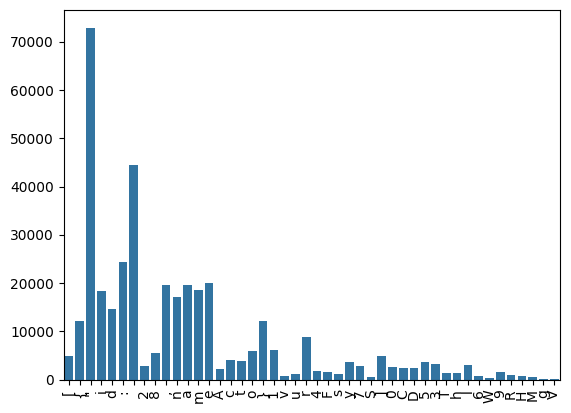

In [8]:
from collections import Counter

all_genres = []
for gen_list in movies['genres']:
    for genre in gen_list:
      all_genres.append(genre)
count_genres = Counter(all_genres)
sns.barplot(x=list(count_genres.keys()), y=list(count_genres.values()))
plt.xticks(rotation=90)
plt.show()

In [9]:
movies.isnull().sum()
movies.dropna(inplace=True)
movies.duplicated().sum()

<ipython-input-9-38f824e37c96>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies.dropna(inplace=True)


0

##Data Cleaning and Preprocessing


In [10]:
def extractNames(movies_gen, stopper=None):
    movies_gen = ast.literal_eval(movies_gen)
    movies_gen = movies_gen[:stopper]
    genreName =[genre['name'] for genre in movies_gen]
    return genreName

movies['genres'] = movies['genres'].apply(extractNames)
movies['cast']= movies['cast'].apply(lambda  x:extractNames(x, stopper=3))
movies['keywords'] = movies['keywords'].apply(extractNames)

def extractNames(movies_crew):
    movies_crew = ast.literal_eval(movies_crew)
    for crew in movies_crew:
        if crew['job'] == 'Director':
            return crew['name'].split(", ")
    return np.nan

movies['crew'] = movies['crew'].apply(extractNames)
movies['overview'] = movies['overview'].apply(lambda x:x.split())

<ipython-input-10-08e1adb72cc7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['genres'] = movies['genres'].apply(extractNames)
<ipython-input-10-08e1adb72cc7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['cast']= movies['cast'].apply(lambda  x:extractNames(x, stopper=3))
<ipython-input-10-08e1adb72cc7>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [11]:

movies['genres'] = movies['genres'].apply(
    lambda x: [i.replace(" ", "") for i in x] if isinstance(x, list) else []
)

movies['keywords'] = movies['keywords'].apply(
    lambda x: [i.replace(" ", "") for i in x] if isinstance(x, list) else []
)

movies['cast'] = movies['cast'].apply(
    lambda x: [i.replace(" ", "") for i in x] if isinstance(x, list) else []
)

movies['crew'] = movies['crew'].apply(
    lambda x: [i.replace(" ", "") for i in x] if isinstance(x, list) else []
)


<ipython-input-11-2253a1fc6d9d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['genres'] = movies['genres'].apply(
<ipython-input-11-2253a1fc6d9d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['keywords'] = movies['keywords'].apply(
<ipython-input-11-2253a1fc6d9d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

In [12]:
print( movies['genres'].apply(lambda x: len(x) == 0).sum() )
print( movies['keywords'].apply(lambda x: len(x) == 0).sum() )
print( movies['cast'].apply(lambda x: len(x) == 0).sum() )
print( movies['crew'].apply(lambda x: len(x) == 0).sum() )

28
411
42
30


##Combining Features to Create Tags and Removing Stopwords

In [13]:
movies['tags'] = movies['overview'] + movies['genres'] + movies['keywords'] + movies['cast'] + movies['crew']

df = movies[['movie_id','title_x','tags']]

df['tags'] = df['tags'].apply(lambda x :" ".join(x))

df['tags'] = df['tags'].apply(lambda x:x.lower())

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    return " ".join(word for word in text.split() if word not in stop_words)

# Apply stopword removal to tags
df['tags'] = df['tags'].apply(remove_stopwords)

<ipython-input-13-d44cb68664f6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['tags'] = movies['overview'] + movies['genres'] + movies['keywords'] + movies['cast'] + movies['crew']
<ipython-input-13-d44cb68664f6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tags'] = df['tags'].apply(lambda x :" ".join(x))
<ipython-input-13-d44cb68664f6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

##TF-IDF Vectorization


In [14]:
#  TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)  # Limit to top 5000 features for efficiency

tfidf_matrix = tfidf.fit_transform(df['tags'])


feature_names = tfidf.get_feature_names_out()

print("TF-IDF Matrix Shape:", tfidf_matrix.shape)


TF-IDF Matrix Shape: (4800, 5000)


In [15]:

cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)


print("Cosine Similarity Matrix Shape:", cosine_sim.shape)  # (number of movies, number of movies)


Cosine Similarity Matrix Shape: (4800, 4800)


##Building the Recommendation Function

In [16]:
def recommend(movie_title, cosine_sim = cosine_sim):
    idx =  df[df['title_x'] == movie_title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6]
    movie_indices = [i[0] for i in sim_scores]

    return df['title_x'].iloc[movie_indices]

recommend('Avatar')

,title_x
3724,Falcon Rising
582,Battle: Los Angeles
3604,Apollo 18
539,Titan A.E.
47,Star Trek Into Darkness


##Testing the Recommendation System


In [17]:
df[df['title_x'] == 'Spider-Man 3']

,movie_id,title_x,tags
5,559,Spider-Man 3,seemingly invincible spider-man goes all-new c...


In [18]:
import pickle
pickle.dump(df[['movie_id', 'title_x']].to_dict(), open('movies_dict.pkl', 'wb'))


In [19]:
pickle.dump(cosine_sim, open('similarity.pkl', 'wb'))

In [20]:
df['title_x'].values

array(['Avatar', "Pirates of the Caribbean: At World's End", 'Spectre',
       ..., 'Signed, Sealed, Delivered', 'Shanghai Calling',
       'My Date with Drew'], dtype=object)

In [25]:
newDf = df[df['title_x'] == 'Avatar']

In [30]:
newDf['movie_id'][0]

19995